In [1]:
from models import *
#from TrialModel import *
from alex_utils import *
import matplotlib.pyplot as plt 
from sklearn.decomposition import SparsePCA
import numpy as np
import torch
import torch.nn.functional as F
import scipy.sparse as sp
import torch.optim as optim
from scipy import sparse
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
adj_pt, Ad_pt, As_pt, x_pt = torch.load('./data/8_rot.pt', map_location=torch.device(device))
(len(adj_pt), adj_pt[0].shape) , (len(Ad_pt), Ad_pt[0].shape) , (len(As_pt), As_pt[0].shape), (len(x_pt), x_pt[0].shape)

((8, torch.Size([8, 8])),
 (8, torch.Size([8, 8])),
 (8, torch.Size([8, 8])),
 (8, torch.Size([8, 512])))

In [3]:
# for example generate a simple dataset and save
A = input_matrix(8)
adj, As, Ad = gen_all_rot(A)
transformer = SparsePCA(n_components=512, random_state=0)
x = gen_x(Ad, transformer)
torch.save((adj, Ad, As, x), './data/8_rot.pt')

/home/amarques/private/ECE 228/project/a_git/GCN_Partionioning/utils.py:249: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


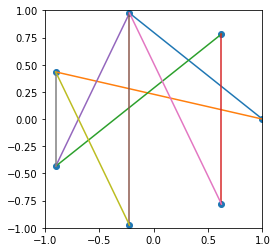

[GraphConvolution (512 -> 64), GraphConvolution (64 -> 16), Linear(in_features=16, out_features=2, bias=True)]
Epoch 0:   Loss = NCut 0.9996310472488403 , Bal 0.3868275582790375
Epoch 20:   Loss = NCut 0.8216733336448669 , Bal 2.9048352241516113
Epoch 40:   Loss = NCut 0.6547582745552063 , Bal 4.205812454223633
Epoch 60:   Loss = NCut 0.643537163734436 , Bal 3.164915084838867
Epoch 80:   Loss = NCut 0.6417229175567627 , Bal 4.018853187561035
tensor([1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.642
Balance Loss = 3.858


tensor([[1.7676e-08, 1.0000e+00],
        [1.0000e+00, 1.7936e-06],
        [6.0377e-05, 9.9994e-01],
        [1.1222e-09, 1.0000e+00],
        [1.1106e-01, 8.8894e-01],
        [9.6888e-09, 1.0000e+00],
        [9.9999e-01, 7.0097e-06]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [4]:
'''
Adjecency matrix and modifications
'''
A = input_matrix(7)
#A = gen_graph(10, 0.4)
plt_graph(A)

# Modifications
A_mod = A + sp.eye(A.shape[0])  # Adding Self Loop
norm_adj = symnormalise(A_mod)  # Normalization using D^(-1/2) A D^(-1/2)
adj = sparse_mx_to_torch_sparse_tensor(norm_adj).to(device) # SciPy to Torch sparse
As = sparse_mx_to_torch_sparse_tensor(A).to(device)  # SciPy to sparse Tensor
A = sparse_mx_to_torch_sparse_tensor(A).to_dense().to(device)   # SciPy to Torch Tensor
#print(A)

'''
Declare Input Size and Tensor
'''
N = A.shape[0]
d = 512

torch.manual_seed(100)
x = torch.randn(N, d)
x = x.to(device)

#transformer = SparsePCA(n_components=d, random_state=0)
#x = torch.from_numpy(transformer.fit_transform(A.cpu())).float().to(device)

'''
Model Definition
'''
gl = [d, 64, 16]
ll = [16, 2]

model = GCN(gl, ll, dropout=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-6)
print(model)

# check_grad(model, x, adj, A, As)

#Train
Train(model, x, adj, As, optimizer, max_epochs=100)

# Test the best partition
Y = Test(model, x, adj, As)
Y

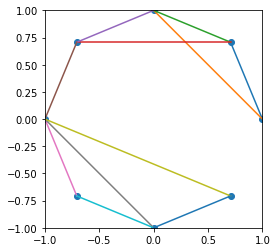

tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.943
Balance Loss = 22.484


In [5]:
A1 = input_matrix(8)

N1 = A1.shape[0]
torch.manual_seed(100)
x1 = torch.randn(N1, d)
x1 = x1.to(device)

#A[0,7] = 2
#A[7,0] = 2
plt_graph(A1)
A_mod1 = A1 + sp.eye(A1.shape[0])  # Adding Self Loop
norm_adj1 = symnormalise(A_mod1)  # Normalization using D^(-1/2) A D^(-1/2)
adj1 = sparse_mx_to_torch_sparse_tensor(norm_adj1).to(device) # SciPy to Torch sparse
As1 = sparse_mx_to_torch_sparse_tensor(A1).to(device)  # SciPy to sparse Tensor
A1 = sparse_mx_to_torch_sparse_tensor(A1).to_dense().to(device)   # SciPy to Torch Tensor
Y1 = Test(model, x1, adj1, As1)
# from here we can see that a single graph being used for training does not provide good results

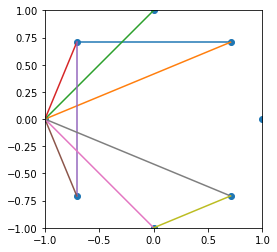

tensor([1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.995
Balance Loss = 1.202


In [6]:
A_gen = gen_graph(8,0.3)
plt_graph(A_gen)
A_mod = A_gen + sp.eye(A_gen.shape[0])  # Adding Self Loop
norm_adj = symnormalise(A_mod)  # Normalization using D^(-1/2) A D^(-1/2)
adj = sparse_mx_to_torch_sparse_tensor(norm_adj).to(device) # SciPy to Torch sparse
As1 = sparse_mx_to_torch_sparse_tensor(A_gen).to(device)  # SciPy to sparse Tensor
A = sparse_mx_to_torch_sparse_tensor(A_gen).to_dense().to(device)   # SciPy to Torch Tensor
x = torch.randn(A.shape[0], d).to(device)
Y = Test(model, x, adj, As1)
# Again single graph is not good, and also generating random graphs
# isn't easy because it could leave floating vertices

In [7]:
'''
Adjecency matrix and modifications
'''
A_og = input_matrix(8)
N = A_og.shape[0]
d = 512

torch.manual_seed(100)
x = torch.randn(N, d)
x = x.to(device)

'''
Model Definition
'''
gl = [d, 64, 32, 16]
ll = [16, 8, 2]

model_r = GCN(gl, ll, dropout=0.5).to(device)
optimizer_r = optim.Adam(model_r.parameters(), lr=5e-4, weight_decay=5e-6)
print(model_r)

# check_grad(model, x, adj, A, As)
#A = input_matrix(8)

#Train
Train_rotate(model_r, x, A_og, optimizer_r, rotate=True, max_epochs = 150)

print("\nTesting all the different rotations\n")

# Test the best partition
#Y = Test_rotate(model_r, x, A_og, rotate=False, s = 'r') # single test
Y = Test_rotate(model_r, x, A_og, s = 'r') # test all rotations give similar partition
#Y # running Test multiple times can generate different results idk why

[GraphConvolution (512 -> 64), GraphConvolution (64 -> 32), GraphConvolution (32 -> 16), Linear(in_features=16, out_features=8, bias=True), Linear(in_features=8, out_features=2, bias=True)]
Epoch 0:   Loss = 0.9999767541885376
Epoch 20:   Loss = 0.9970415234565735
Epoch 40:   Loss = 0.9792026877403259
Epoch 60:   Loss = 0.8716031312942505
Epoch 80:   Loss = 0.30555084347724915
Epoch 100:   Loss = 0.18546846508979797
Epoch 120:   Loss = 0.18184340000152588
Epoch 140:   Loss = 0.1818181872367859

Testing all the different rotations

tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.182
tensor([0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.182
tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.183
tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.182
tensor([0, 0, 0, 0,

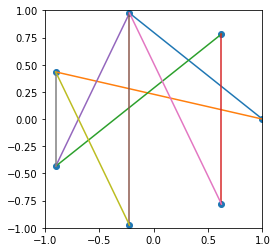

tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 1.006
tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 1.001
tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 1.001
tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 1.000
tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.994
tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 1.006
tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 1.004


In [8]:
A7 = input_matrix(7)
x7 = torch.randn(7, d).to(device)
#A7 = graph_resize(A7, 8, 'one')
plt_graph(A7)
Y1 = Test_rotate(model_r, x7, A7, rotate=True,s = 'r')

In [9]:
'''
Adjecency matrix and modifications
'''
A_og = input_matrix(8)

N = A_og.shape[0]
d = 512

torch.manual_seed(100)
x = torch.randn(N, d)
x = x.to(device)

'''
Model Definition
'''
gl = [d, 64, 32, 16]
ll = [16, 8, 2]

model_r = GCN(gl, ll, dropout=0.5).to(device)
optimizer_r = optim.Adam(model_r.parameters(), lr=5e-4, weight_decay=5e-6)
print(model_r)

# check_grad(model, x, adj, A, As)
#A = input_matrix(8)

#Train
Train_random(model_r, x, A_og, optimizer_r, max_epochs = 150)

# Test the best partition
#Y = Test_rotate(model_r, x, A_og, rotate=False, s = 'r') # single test
Y = Test_rotate(model_r, x, A_og, s = 'rand') # test all rotations give similar partition
#Y # running Test multiple times can generate different results idk why
# using the random graphs to train is not as good as just rotating graphs

[GraphConvolution (512 -> 64), GraphConvolution (64 -> 32), GraphConvolution (32 -> 16), Linear(in_features=16, out_features=8, bias=True), Linear(in_features=8, out_features=2, bias=True)]
Epoch 0:   Loss = 0.9999767541885376
Epoch 20:   Loss = 1.0
Epoch 40:   Loss = 0.9711276888847351
Epoch 60:   Loss = 0.9991264343261719
Epoch 80:   Loss = 0.7990475296974182
Epoch 100:   Loss = 1.0090488195419312
Epoch 120:   Loss = 0.23226037621498108
Epoch 140:   Loss = 1.0
tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.995
tensor([0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.995
tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
!!! Mismatch: expected = tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Normalized Cut obtained using the above partition is : 1.000
tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Normalized Cut obtained using the above partition is : 0.996
tensor([0, 0, 

In [10]:
# Just run all the functions to show the results of partition
print("Cuts: ", cuts(A_og, Y[0].to(device)).tolist())

print("Volume: ", volume(A_og, Y[0].to(device)).tolist())

print("Normalized Cut: ", NCut(A_og, Y[0].to(device)).item())

print("Balance: ", balance(Y[0].to(device)).item(), "< test vs train >", balance(Y[0].to(device), False).item())

Cuts:  [1.0, 1.0]
Volume:  [11.0, 11.0]
Normalized Cut:  0.1818181872367859
Balance:  0.0 < test vs train > 0.17725560069084167


In [11]:
d = transformer.components_.shape[0]

torch.manual_seed(100)
#x = torch.randn(N, d)
#x = x.to(device)

'''
Model Definition
'''
gl = [d, 64, 16]
ll = [16, 2]

model = GCN(gl, ll, dropout=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-6)
print(model)

# have an initial test to benchmark the performance of model
Y, l_Y = Test_custom(model, x_pt[0], adj_pt[0], As_pt[0], './data/weigths_N8_L8.pt')
# check_grad(model, x1[0], adj1[0], Ad[0], As[0])

#Train
Train_arr(model, x_pt, adj_pt, As_pt, optimizer, max_epochs=100, min_loss=l_Y)

# Test the best partition
Y, l_Y = Test_custom(model, x_pt[0], adj_pt[0], As_pt[0], './data/weigths_N8_L8.pt')
Y, l_Y

[GraphConvolution (512 -> 64), GraphConvolution (64 -> 16), Linear(in_features=16, out_features=2, bias=True)]
tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Using partition : Normalized Cut = 0.182 , Balance loss = 0.182
Min loss to save is 0.1818181872367859
Epoch 0:   Loss : avg = 0.1818181872367859 , NCut = 0.1818181872367859 , balance = 0.0
Epoch 20:   Loss : avg = 0.18181823194026947 , NCut = 0.18181821703910828 , balance = 5.684341886080802e-14
Epoch 40:   Loss : avg = 0.18181836605072021 , NCut = 0.18181845545768738 , balance = 1.4210854715202004e-12
Epoch 60:   Loss : avg = 0.18181847035884857 , NCut = 0.18181833624839783 , balance = 1.4210854715202004e-12
Epoch 80:   Loss : avg = 0.18181836605072021 , NCut = 0.18181829154491425 , balance = 4.547473508864641e-13
tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Using partition : Normalized Cut = 0.182 , Balance loss = 0.182


(tensor([[4.9651e-11, 1.0000e+00],
         [2.9030e-11, 1.0000e+00],
         [2.9030e-11, 1.0000e+00],
         [4.5977e-08, 1.0000e+00],
         [1.0000e+00, 1.0707e-09],
         [1.0000e+00, 9.5650e-09],
         [1.0000e+00, 4.2026e-10],
         [1.0000e+00, 9.5650e-09]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 0.1818181872367859)

In [22]:
transformer = SparsePCA(n_components=64, random_state=0)
adj_pt = []; Ad_pt = []; As_pt = []; x_pt = [];

while(len(x_pt) < 20): # try to generate more graphs
    gg = gen_graph(torch.randint(10,100, (1,)).item(), torch.rand((1,)).item() * 2/5)
    #plt_graph(gg)
    #gg.toarray().sum(0) , 0 not in gg.toarray().sum(0)
    gga = gg.toarray()
    idx = np.array([0]) #start traversing the graph from first vertex
    conn = True
    for i in range(gg.shape[0]):
        if i >= idx.shape[0]:
            conn = False
            print("Not connected")
            break;
        new_idx = np.arange(gg.shape[0])[gga[idx[i]]>0] # all the vertices the curr vertex is connected to
        idx, idx_o = np.unique(np.append(idx, new_idx), return_index=True) # add newly seen vertices to list
        idx = idx[idx_o.argsort()] # unsort them so that we dont recheck the same vertices
    if conn:
        print(f"Appending new graph of size {gg.shape[0]}")
        adj_gg, As_gg, A_gg = gen_all_rot(gg, 1)
        x_gg = gen_x(A_gg, transformer)
        adj_pt.append(adj_gg[0])
        Ad_pt.append(A_gg[0])
        As_pt.append(As_gg[0])
        x_pt.append(x_gg[0])
torch.save((adj_pt, Ad_pt, As_pt, x_pt), './data/gen_100_40.pt')

Not connected
Appending new graph of size 93
Appending new graph of size 21
Not connected
Not connected
Appending new graph of size 58
Appending new graph of size 60
Appending new graph of size 48
Appending new graph of size 49
Not connected
Appending new graph of size 90
Appending new graph of size 84
Appending new graph of size 97
Appending new graph of size 90
Not connected
Not connected
Appending new graph of size 92
Appending new graph of size 27
Appending new graph of size 12
Appending new graph of size 49
Appending new graph of size 99
Appending new graph of size 18
Appending new graph of size 69
Appending new graph of size 47
Appending new graph of size 86
Not connected
Appending new graph of size 66


In [23]:
adj_pt, Ad_pt, As_pt, x_pt = torch.load('./data/gen_100_40.pt', map_location=torch.device(device))
(len(adj_pt), adj_pt[0].shape) , (len(Ad_pt), Ad_pt[0].shape) , (len(As_pt), As_pt[0].shape), (len(x_pt), x_pt[0].shape)

((20, torch.Size([93, 93])),
 (20, torch.Size([93, 93])),
 (20, torch.Size([93, 93])),
 (20, torch.Size([93, 64])))

In [ ]:
d = transformer.components_.shape[0]

torch.manual_seed(100)

'''
Model Definition
'''
gl = [d, 64, 32]
ll = [32, 16, 2]

model = GCN(gl, ll, dropout=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-6)
print(model)

# have an initial test to benchmark the performance of model
#Y, l_Y = Test_custom(model, x_pt[0], adj_pt[0], As_pt[0], './data/w_100_40.pt')
# check_grad(model, x1[0], adj1[0], Ad[0], As[0])

#Train
Train_arr(model, x_pt, adj_pt, As_pt, optimizer, file_s='./data/w_100_40.pt',max_epochs=200, min_loss=1000)#l_Y)

# Test the best partition
Y, l_Y = Test_custom(model, x_pt[0], adj_pt[0], As_pt[0], './data/w_100_40.pt')
Y, l_Y

[GraphConvolution (64 -> 64), GraphConvolution (64 -> 32), Linear(in_features=32, out_features=16, bias=True), Linear(in_features=16, out_features=2, bias=True)]
Model not saved before, training from scratch
Min loss to save is 1000
Epoch 0:   Loss : avg = 0.9999949932098389 , NCut = 0.9999950528144836 , balance = 0.0
Epoch 20:   Loss : avg = 1.0000017881393433 , NCut = 0.9999952912330627 , balance = 0.017586709931492805
Epoch 40:   Loss : avg = 0.9999996423721313 , NCut = 0.9999996423721313 , balance = 2.33982515335083


## Improvements that could be done:

- include graphSAGE, from: https://github.com/williamleif/GraphSAGE
- change balance loss -> k-partitions
    - currently makes the algorithm guess equal for all partitions
    - if used after on a pretrained model doesn't affect model much
- get larger dataset